# import

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
import xgboost as xgb
import time

%matplotlib inline

# load data

In [14]:
# From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

# ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(df_train['price_doc'].values)
id_test = df_test['id']
id_train = df_train['id']

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
df_all.set_index('id', inplace=True)

# 更新build_year
build_year_new = pd.read_csv('../output/feat/BuildYearNew-NaiveXgbMixture-SingleDefault2017060200.csv', index_col='id')
df_all['gaoyl_build_year_state'] = 0
df_all.loc[df_all.build_year.isnull(), 'gaoyl_build_year_state'] = -1
df_all.loc[df_all.build_year.notnull() & df_all.build_year <= 1800, 'gaoyl_build_year_state'] = df_all.loc[df_all.build_year.notnull() & df_all.build_year <= 1800, 'build_year']
df_all.drop(['build_year'], axis=1, inplace=True)
df_all['build_year'] = build_year_new.build_year
df_all['gaoyl_time_offset'] = df_all.timestamp.dt.year - df_all.build_year

# 更新state
state_new = pd.read_csv('../output/feat/StateNew-NaiveXgbMixture-SingleDefault2017060402-WithPrice.csv', index_col='id')
df_all['gaoyl_state_state'] = 0
df_all.loc[df_all.state.isin((1, 2, 3, 4)), 'gaoyl_state_state'] = 1
df_all['state'] = state_new.state

# Add month-year
# 新特征 哪年哪月（交易量）
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
# 新特征 一年中的第几周（交易量）
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
# 新特征 几月份（交易 ）和 星期几（交易）
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

sub_area_map = df_all.sub_area.value_counts().to_dict()
df_all['gaoyl_subarea_cnt'] = df_all.sub_area.map(sub_area_map)

# 删除多余的列
to_drop = ['price_doc', 'timestamp', 'gaoyl_rest_sq']
df_all.drop(filter(lambda x: x in df_all.columns, to_drop), axis=1, inplace=True)

# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(38133L, 312L)
('X_train_all shape is', (30471L, 312L))
('X_train shape is', (24377L, 312L))
('y_train shape is', (24377L,))
('X_val shape is', (6094L, 312L))
('y_val shape is', (6094L,))
('X_test shape is', (7662L, 312L))


# xgboost single

* naive-xgb Best iteration : [247]	val-rmse:0.420493
* build_year : [239]	val-rmse:0.420128
* state-single00 :[220]	val-rmse:0.421898
* state-single01 : [278]	val-rmse:0.422102
* state-single02-withPrice : [258]	val-rmse:0.421543

## best round + 20

In [15]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, evals=[(dval, 'val')],
                          num_boost_round=1000,
                          early_stopping_rounds=25,
                          verbose_eval=25)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.4764
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.11461
[50]	val-rmse:1.2784
[75]	val-rmse:0.579922
[100]	val-rmse:0.452514
[125]	val-rmse:0.430429
[150]	val-rmse:0.425274
[175]	val-rmse:0.423318
[200]	val-rmse:0.42241
[225]	val-rmse:0.421982
[250]	val-rmse:0.421736
[275]	val-rmse:0.42185
Stopping. Best iteration:
[258]	val-rmse:0.421543



## best round + 20 feature importance

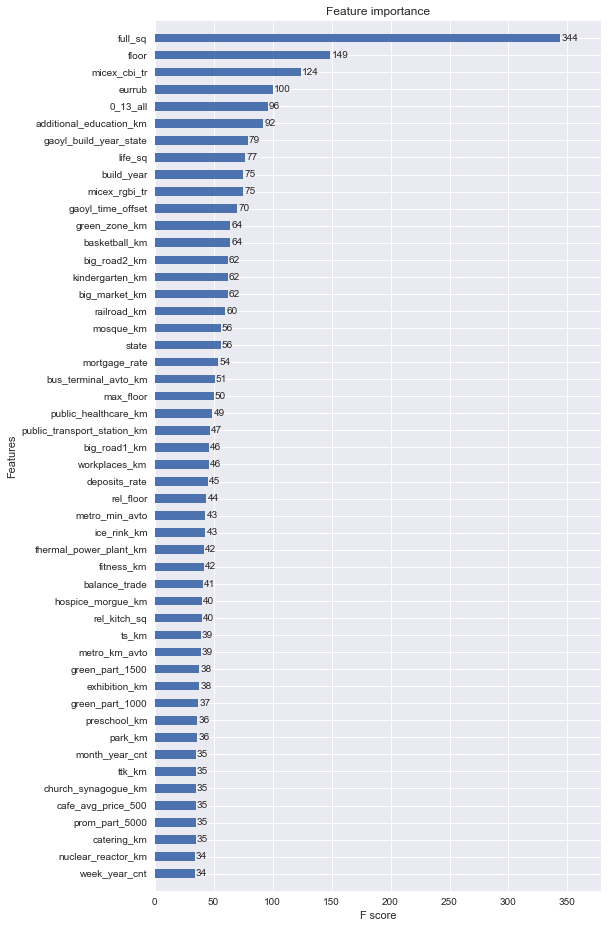

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)

## correlation analysis

D:\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
D:\Anaconda2\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


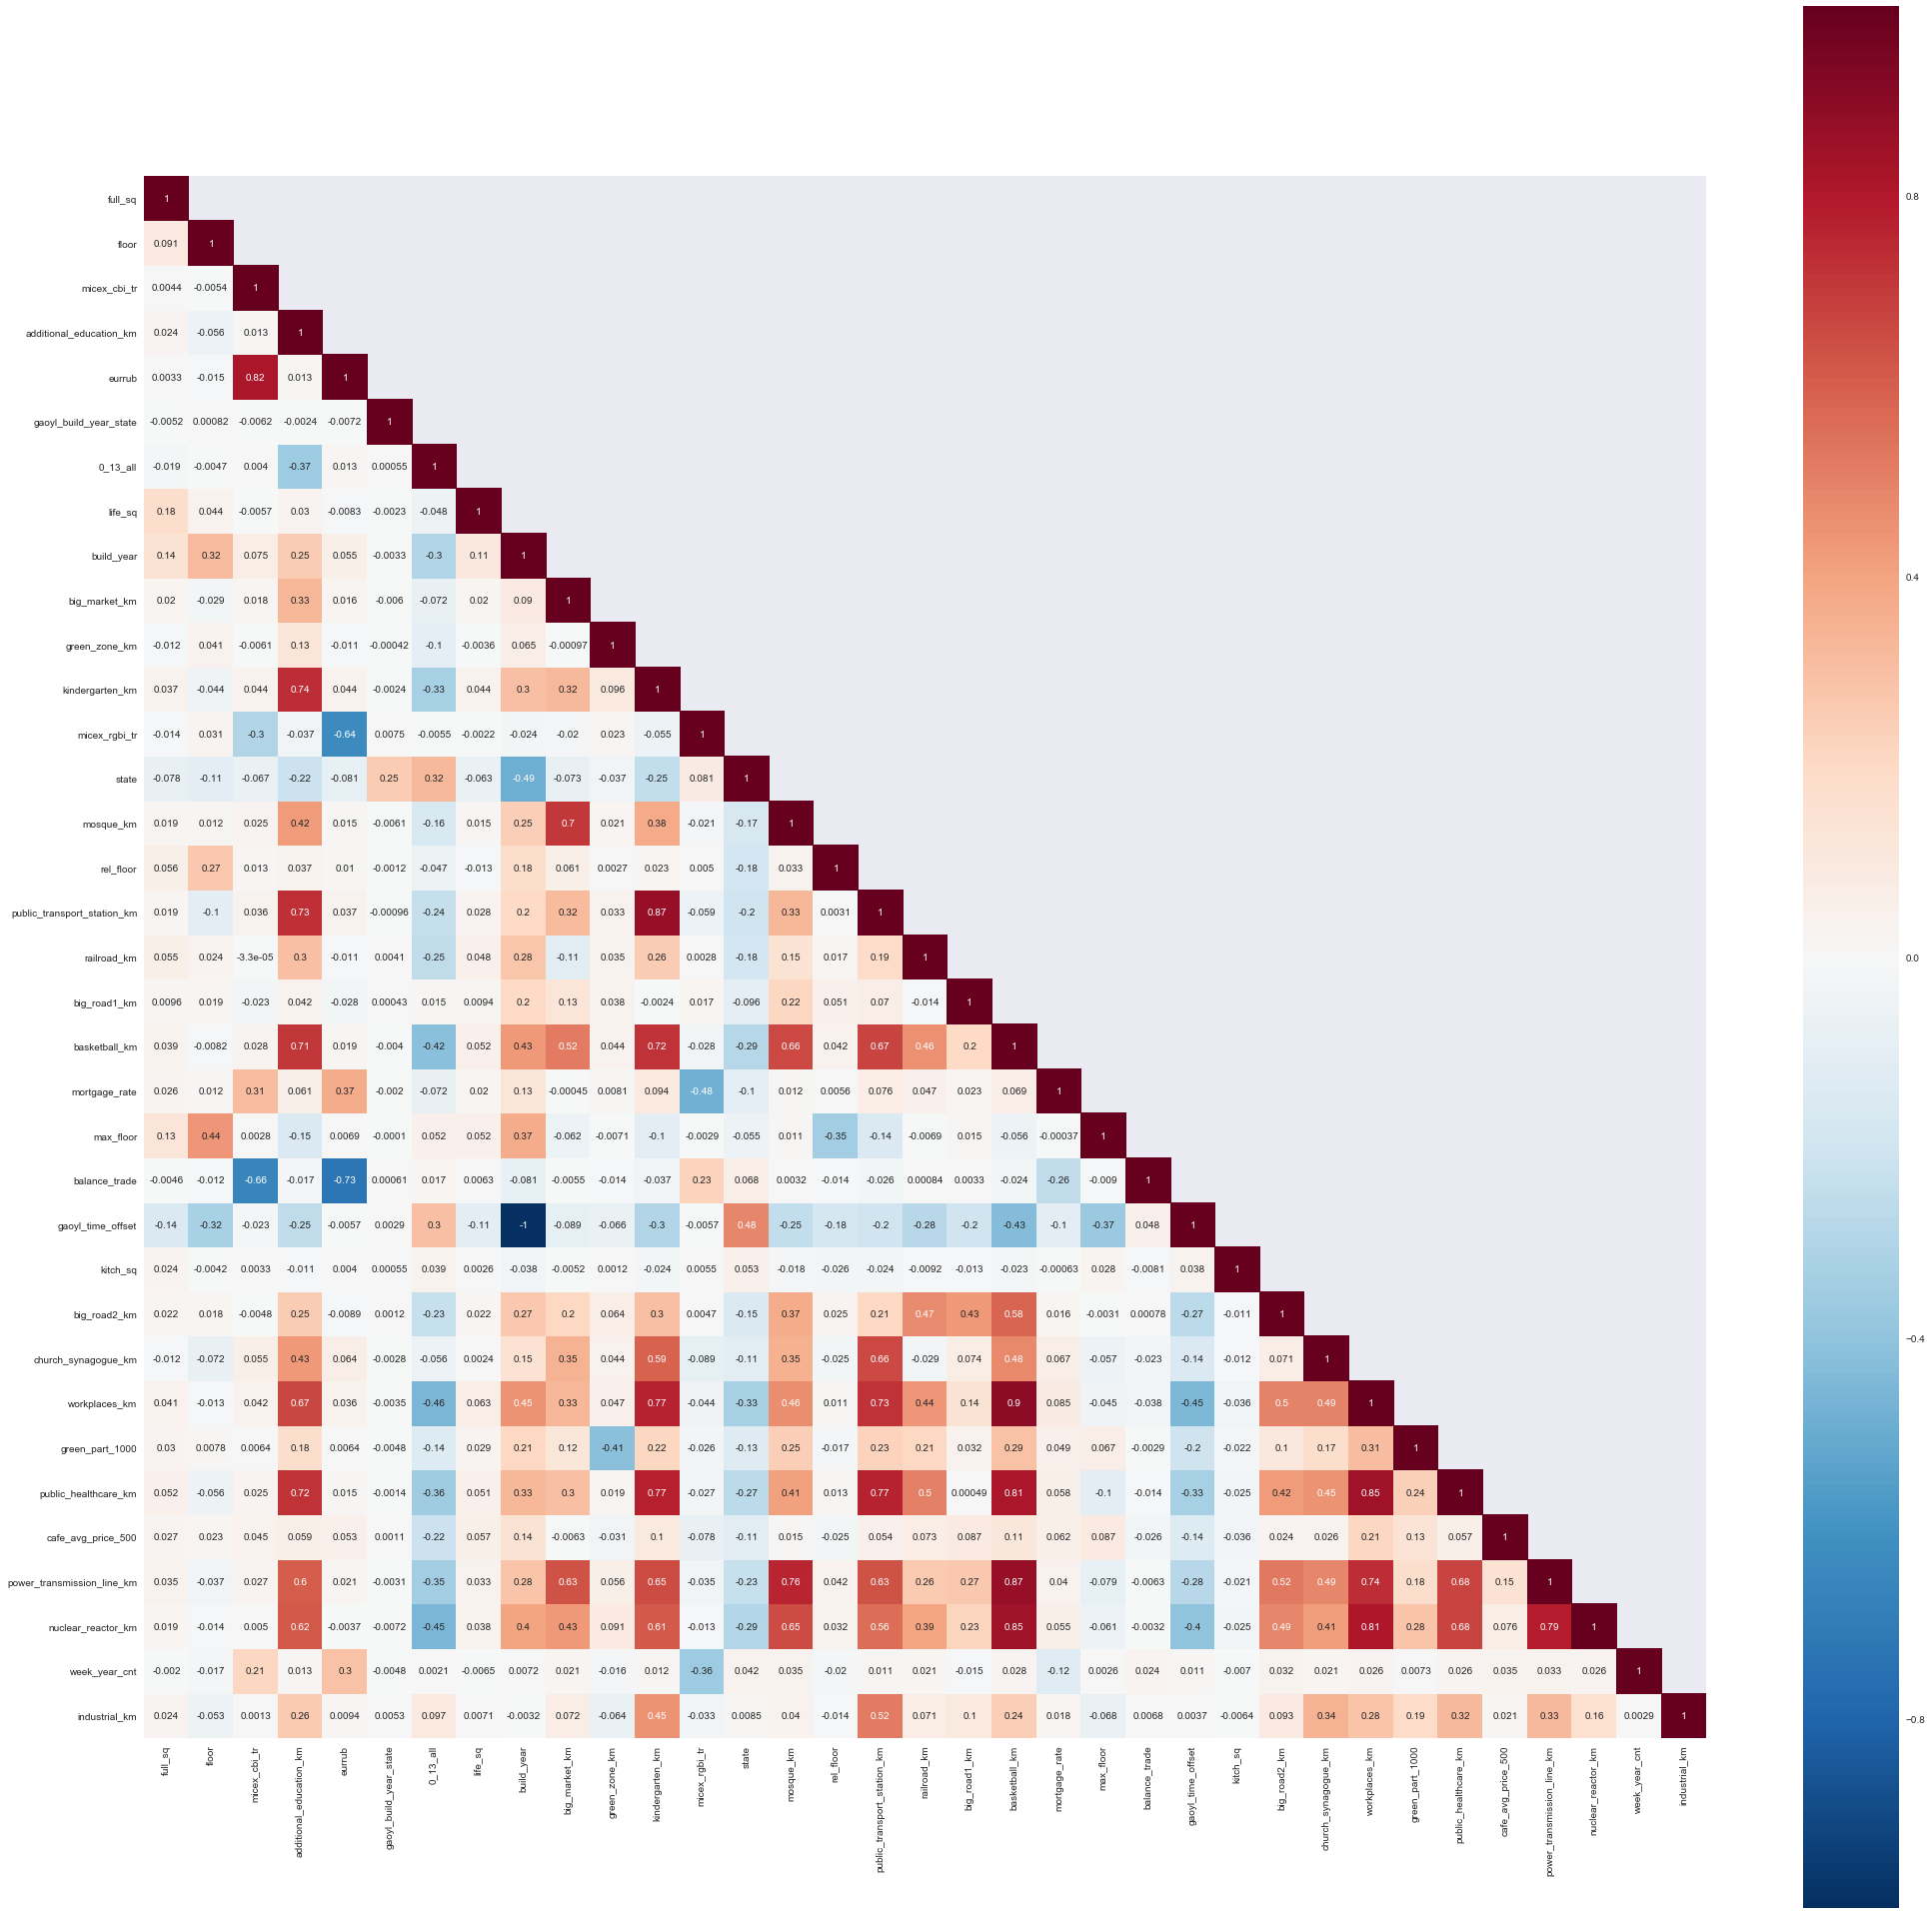

In [21]:
partial_model_fscore = partial_model.get_fscore()
partial_model_fscore = sorted(partial_model_fscore.items(), key=lambda x: x[1], reverse=True)
top_features = map(lambda x: x[0], partial_model_fscore[:35])
# top_features.append('price_doc')

corr_matt = df_all[top_features].corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(35, 35))
sns.heatmap(corr_matt, mask=mask, vmax=.8, square=True, annot=True)

## best round

In [22]:
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

## best round feature importance

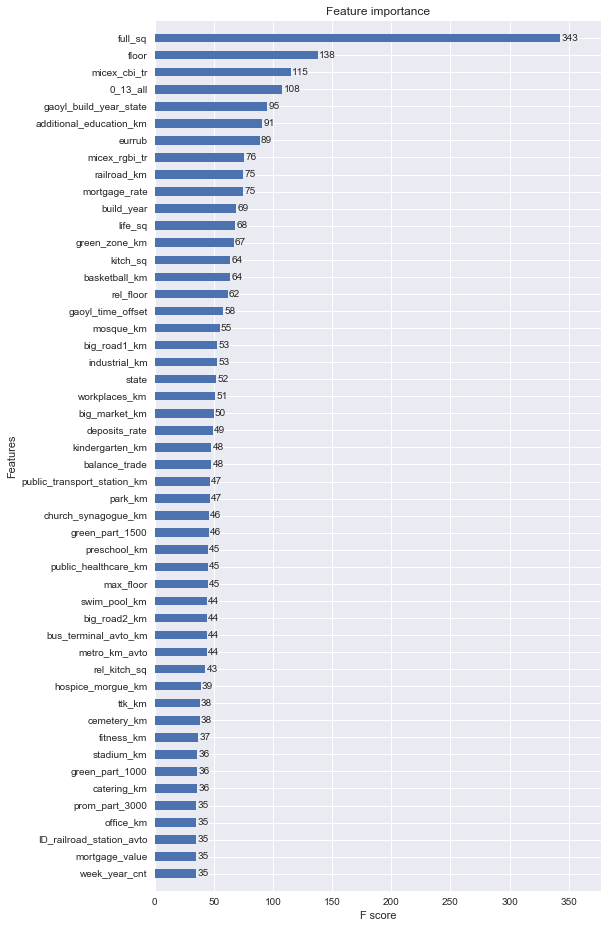

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

## best round prediction

In [24]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('../output/single/Submission-NaiveXgb-WithPredictedBuildYear-SingleModel.csv', index=False)

# xgboost stacking

[0]	val-rmse:14.3587
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.00887
[50]	val-rmse:1.20024
[75]	val-rmse:0.558586
[100]	val-rmse:0.47248
[125]	val-rmse:0.463847
[150]	val-rmse:0.462329
[175]	val-rmse:0.461818
[200]	val-rmse:0.461315
[225]	val-rmse:0.461335
[250]	val-rmse:0.460991
Stopping. Best iteration:
[240]	val-rmse:0.460887

[0]	val-rmse:14.3798
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.02935
[50]	val-rmse:1.21488
[75]	val-rmse:0.560391
[100]	val-rmse:0.465031
[125]	val-rmse:0.453676
[150]	val-rmse:0.451134
[175]	val-rmse:0.450191
[200]	val-rmse:0.449949
[225]	val-rmse:0.449857
[250]	val-rmse:0.44971
[275]	val-rmse:0.44978
Stopping. Best iteration:
[262]	val-rmse:0.449558

[0]	val-rmse:14.3561
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.00452
[50]	val-rmse:1.19977
[75]	val-rmse:0.566417
[100]	val-rmse:0.48349
[125]	val-rmse:0.475044
[150]	val-rmse:0.47328
[175]	val-rmse:0.472655
[200]	val-rmse:0.472268
[225]	val-rmse:0.47163
[250]	val-rmse:0.471275
[275]	val-rmse:0.471096
[300]	val-rmse:0.471008
Stopping. Best iteration:
[287]	val-rmse:0.470986

[0]	val-rmse:14.3779
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.02287
[50]	val-rmse:1.20794
[75]	val-rmse:0.556847
[100]	val-rmse:0.465476
[125]	val-rmse:0.454908
[150]	val-rmse:0.452888
[175]	val-rmse:0.452301
[200]	val-rmse:0.451806
[225]	val-rmse:0.451739
[250]	val-rmse:0.451515
[275]	val-rmse:0.451327
[300]	val-rmse:0.451436
Stopping. Best iteration:
[280]	val-rmse:0.451242

[0]	val-rmse:14.3603
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.01049
[50]	val-rmse:1.20299
[75]	val-rmse:0.561595
[100]	val-rmse:0.475948
[125]	val-rmse:0.467475
[150]	val-rmse:0.465742
[175]	val-rmse:0.465219
[200]	val-rmse:0.46509
[225]	val-rmse:0.46458
[250]	val-rmse:0.464638
Stopping. Best iteration:
[228]	val-rmse:0.464534

In [16]:
import sys
sys.path.append('..')
from my_py_models.stacking import Stacking
from my_py_models.my_xgb_classifier import MyXgbClassifier

In [17]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

clf = MyXgbClassifier(xgb_params)
stacking = Stacking(5, [clf])
pred_oof, pred_test = stacking.fit_predict(X_train_all, ylog_train_all, X_test)

[0]	val-rmse:14.3587
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.00855
[50]	val-rmse:1.20088
[75]	val-rmse:0.559749
[100]	val-rmse:0.473471
[125]	val-rmse:0.464586
[150]	val-rmse:0.462567
[175]	val-rmse:0.462321
[200]	val-rmse:0.461471
[225]	val-rmse:0.460937
[250]	val-rmse:0.460699
[275]	val-rmse:0.460577
[300]	val-rmse:0.460355
Stopping. Best iteration:
[294]	val-rmse:0.460325

[0]	val-rmse:14.3798
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.02896
[50]	val-rmse:1.21475
[75]	val-rmse:0.559898
[100]	val-rmse:0.464205
[125]	val-rmse:0.452462
[150]	val-rmse:0.450162
[175]	val-rmse:0.449025
[200]	val-rmse:0.448769
[225]	val-rmse:0.448474
[250]	val-rmse:0.448476
[275]	val-rmse:0.448134
[300]	val-rmse:0.448173
Stopping. Best iteration:
[277]	val-rmse:0.448117

[0]	val-rmse:14.3561
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.0045
[50]	val-rmse:1.19996
[75]	val-rmse:0.565932
[100]	val-rmse:0.482486
[125]	val-r

## oof value
1. 0.460019246439
2. 0.458690181301

In [18]:
from sklearn.metrics import mean_squared_error

print pred_oof.shape
print pred_test.shape

for pred_oof_single in pred_oof.T:
    print np.sqrt(mean_squared_error(pred_oof_single, ylog_train_all))

(30471L, 1L)
(7662L, 1L)
0.458690181301


## stacking prediction

In [19]:
y_pred = np.exp(pred_test[:, 0]) - 1
y_oof = np.exp(pred_oof[:, 0]) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
df_sub.to_csv('../output/stacking/Submission-NaiveXgb-MissingValue2-Stacking-2017060400-Test.csv', index=False)

df_oof = pd.DataFrame({'id': id_train, 'price_doc': y_oof})
df_oof.to_csv('../output/stacking/Submission-NaiveXgb-MissingValue2-Stacking-2017060400-OutOfFold.csv', index=False)